# Mod 5 Project : Flight delays at Newark Airport
### Khairul Omar & Ly Nguyenova

# Table of Contents
1. Executive Summary
2. Data Import
3. Data Cleansing
4. Exploratory Data Analysis
5. Feature Selection
6. Prepare for Modelling
7. Train and Evaluate Models  
    7.1 Logistic Regression - Baseline  
    7.2 Decision Trees  
    7.3 Random Forests  
    7.4 AdaBoost  
    7.5 Gradient Boost  
    7.6 Support Vector Machines
8. Finalize Model  
    8.1 Model Selection  
    8.2 Feature Importance  
    8.3 Threshold Selection  
    8.4 Evaluate with Test data
9. Conclusion and Recommendations

# 1. Executive Summary
We are working on model to predict if a flight will be delayed in Newark Airport on behalf our the its largest operator, United Airlines. Our findings will help our client to address the following issues:
1. Mission 1
2. Mission 2
3. Mission 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import progressbar
import warnings
import time
from datetime import datetime
from library import *
warnings.simplefilter("ignore")

# 2. Data Import

In [2]:
df = pd.read_csv('newark_flights.csv')
df.columns

Index(['Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

# 3. Data Cleansing

### 3.1 First round of cleansing

In [3]:
# Clean up null

df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop(df[(df['ORIGIN_AIRPORT']=='EWR') & (df['DEPARTURE_TIME'].isna())].index, inplace=True)
df.drop(df[(df['DESTINATION_AIRPORT']=='EWR') & (df['ARRIVAL_TIME'].isna())].index, inplace=True)
df.drop(df[(df['ARRIVAL_DELAY'].isna())].index, inplace=True)
delay = list(df[df.columns[-6:]].columns)
for cols in delay:
    if df[cols].isna().any():
        df[cols].fillna(value=0, inplace=True)

In [4]:
# df.isna().sum()

In [5]:
# Clean up date format
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

# Clean up Arrival time format
df["HOUR"] = df["SCHEDULED_ARRIVAL"].apply(lambda x: int(str(int(x))[0:2]) if len(str(int(x)))==4 else int(str(int(x))[0:1]))
df["MINUTE"]  = df["SCHEDULED_ARRIVAL"].apply(lambda x: int(str(int(x))[-2:]))
df["SCHEDULED_ARRIVAL"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR', 'MINUTE']])
df["SCH_ARR_TEMP"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR']])

# Clean up Departure time format
df["HOUR"] = df["SCHEDULED_DEPARTURE"].apply(lambda x: int(str(int(x))[0:2]) if len(str(int(x)))==4 else int(str(int(x))[0:1]))
df["MINUTE"]  = df["SCHEDULED_DEPARTURE"].apply(lambda x: int(str(int(x))[-2:]))
df["SCHEDULED_DEPARTURE"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR', 'MINUTE']])
df["SCH_DEP_TEMP"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR']])

# Temporary column for Darksky data mapping
df["NYC_TIME_TEMP"] = df.apply(lambda row: row['SCH_ARR_TEMP'] if row['DESTINATION_AIRPORT'] == 'EWR' else row['SCH_DEP_TEMP'], axis=1)

# Combine United Express (EV) as mainline United (UA)
df['AIRLINE'] = df.apply(lambda row: 'UA' if row['AIRLINE'] == 'EV' else row['AIRLINE'], axis=1)

# Simplify delay reason columns - for EDA only, not as predictors
df['DELAY_REASON'] = df.apply(lambda row: 'Air system' if row['AIR_SYSTEM_DELAY'] == 1 else 
                              ('Security' if row['SECURITY_DELAY'] == 1 else 
                               ('Airline' if row['AIRLINE_DELAY'] == 1 else 
                                ('Late aircraft' if row['LATE_AIRCRAFT_DELAY'] == 1 else 
                                 ('Weather' if row['WEATHER_DELAY'] == 1 else 0)))), axis=1)
    
# Dummy variables for Arrival or Departure
df['DEPARTURE'] = df.apply(lambda row: 0 if row['DESTINATION_AIRPORT'] == 'EWR' else 1, axis=1)

# Time in reference to Newark only
df['SCHEDULED_TIME'] = df.apply(lambda row: row['SCHEDULED_DEPARTURE'] if row['DEPARTURE'] == 1 else row['SCHEDULED_ARRIVAL'], axis=1)

# Time in reference to Newark only - Hour
df['SCHEDULED_HOUR'] = df['SCHEDULED_TIME'].apply(lambda row: row.hour)

# Dummy variables for target (Delay)
df['DELAY'] = df.apply(lambda row: 1 if (row['DEPARTURE']==1)&(row['DEPARTURE_DELAY']>15) else (1 if (row['DEPARTURE']==0)&(row['ARRIVAL_DELAY']>15) else 0), axis=1)

In [6]:
# Retain only relevant columns

keep_columns = ['DATE', 'DAY_OF_WEEK', 'SCHEDULED_HOUR', 'DEPARTURE', 'AIRLINE',
                'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 'DELAY', 'DELAY_REASON']
temp_columns = ['NYC_TIME_TEMP', 'TAIL_NUMBER'] # temporary for mapping only
df = df[keep_columns + temp_columns]

### 3.2 Join external data on Weather and Aircraft Age

In [7]:
# Import and clean DarkSky weather database
# See separate notbook: dark_sky.ipynb for details on data extraction

weather = pd.DataFrame(pd.read_csv('newark_weather.csv')) # saved output from DarkSky
weather.drop('Unnamed: 0', axis=1, inplace=True)
weather['temperature'] = weather['temperature'].apply(lambda row: round(row,1))
weather['nyc_time'] = pd.to_datetime(weather['nyc_time'])
weather = weather.rename(columns={'icon':'weather'})
weather = weather.set_index('nyc_time')
weather = weather[weather.columns[:-4]]
weather.head()

,weather,precipIntensity,temperature,windSpeed,visibility
nyc_time,,,,,
2015-01-01 00:00:00,clear,0.0,-4.4,1.66,9.997
2015-01-01 01:00:00,clear,0.0,-4.4,1.91,9.997
2015-01-01 02:00:00,clear,0.0,-4.4,2.38,9.997
2015-01-01 03:00:00,clear,0.0,-5.0,1.85,9.997
2015-01-01 04:00:00,clear,0.0,-4.4,2.77,9.997


In [8]:
# Join main data with DarkSky weather database

df = df.join(weather, on='NYC_TIME_TEMP')
df.drop('NYC_TIME_TEMP', axis=1, inplace=True)

In [9]:
# Import plane registration database from FAA
# See separate notbook: plane_registration.ipynb for details on data extraction

plane_reg = pd.DataFrame(pd.read_csv('newark_plane_reg.csv'))
plane_reg.drop('Unnamed: 0', axis=1, inplace=True)
plane_reg = plane_reg.set_index('N-Number')
plane_reg.head()

,Registered
N-Number,
N438WN,2003-07-21
N68061,2002-03-08
N914UY,2014-11-07
N446UA,1998-07-02
N18120,2005-02-25


In [10]:
# Join main data with plane registration database from FAA

df = df.join(plane_reg, on='TAIL_NUMBER')
df.drop(df[(df['Registered'].isna())].index, inplace=True)
df.drop('TAIL_NUMBER', axis=1, inplace=True)

df['planeAge'] = df['DATE'] - pd.to_datetime(df['Registered'])
df['planeAge'] = df['planeAge'].apply(lambda row: row.total_seconds()/365/24/60/60 if row.total_seconds() > 0 else 0)
df.drop('Registered', axis=1, inplace=True)
df = df.dropna()
df.head()

,DATE,DAY_OF_WEEK,SCHEDULED_HOUR,DEPARTURE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,DELAY,DELAY_REASON,weather,precipIntensity,temperature,windSpeed,visibility,planeAge
0,2015-01-01,4,5,0,UA,SJU,EWR,1608,0,0,clear,0.0,-4.4,0.00,9.997,4.961644
1,2015-01-01,4,5,0,B6,SJU,EWR,1608,0,0,clear,0.0,-4.4,0.00,9.997,10.147945
2,2015-01-01,4,5,0,UA,BQN,EWR,1585,0,0,clear,0.0,-4.4,0.00,9.997,9.495890
3,2015-01-01,4,7,0,UA,JAX,EWR,820,0,0,clear,0.0,-5.6,1.46,9.997,11.200000
4,2015-01-01,4,7,0,UA,CHS,EWR,628,0,0,clear,0.0,-5.6,1.46,9.997,13.706849


### 3.3 Retain relevant data only

In [11]:
# Assign df0 for all columns for analysis and visualization

df0 = df.copy()

# Create dummy variables for categorical columns:

df['United'] = df.apply(lambda row: 1 if row['AIRLINE'] == 'UA' else 0, axis=1)
df = pd.get_dummies(df, prefix=['weather'], columns=['weather'])

# Remove dummy columns to avoid multicollinearity

dummy_drop = ['weather_clear', 'weather_partly-cloudy']
df.drop(dummy_drop, axis=1, inplace=True)

# Assign df using only columns relevant to modelling

drop_list = ['DATE', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
             'DELAY_REASON', 'visibility', 'precipIntensity']
df.drop(drop_list, axis=1, inplace=True)

In [12]:
# for col in df.columns:
#     print(col, '\n', df[col].value_counts(), '\n\n')

# 4. Exploratory Data Analysis

In [13]:
# Subset delayed vs ontime flights

dfdelay1 = df0[df0['DELAY']==1]
dfdelay0 = df0[df0['DELAY']==0]
display(df0.columns)
print(f'{int(len(dfdelay1)/len(df0)*100)}% of flights were delayed in Newark in 2015')

Index(['DATE', 'DAY_OF_WEEK', 'SCHEDULED_HOUR', 'DEPARTURE', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 'DELAY',
       'DELAY_REASON', 'weather', 'precipIntensity', 'temperature',
       'windSpeed', 'visibility', 'planeAge'],
      dtype='object')

22% of flights were delayed in Newark in 2015


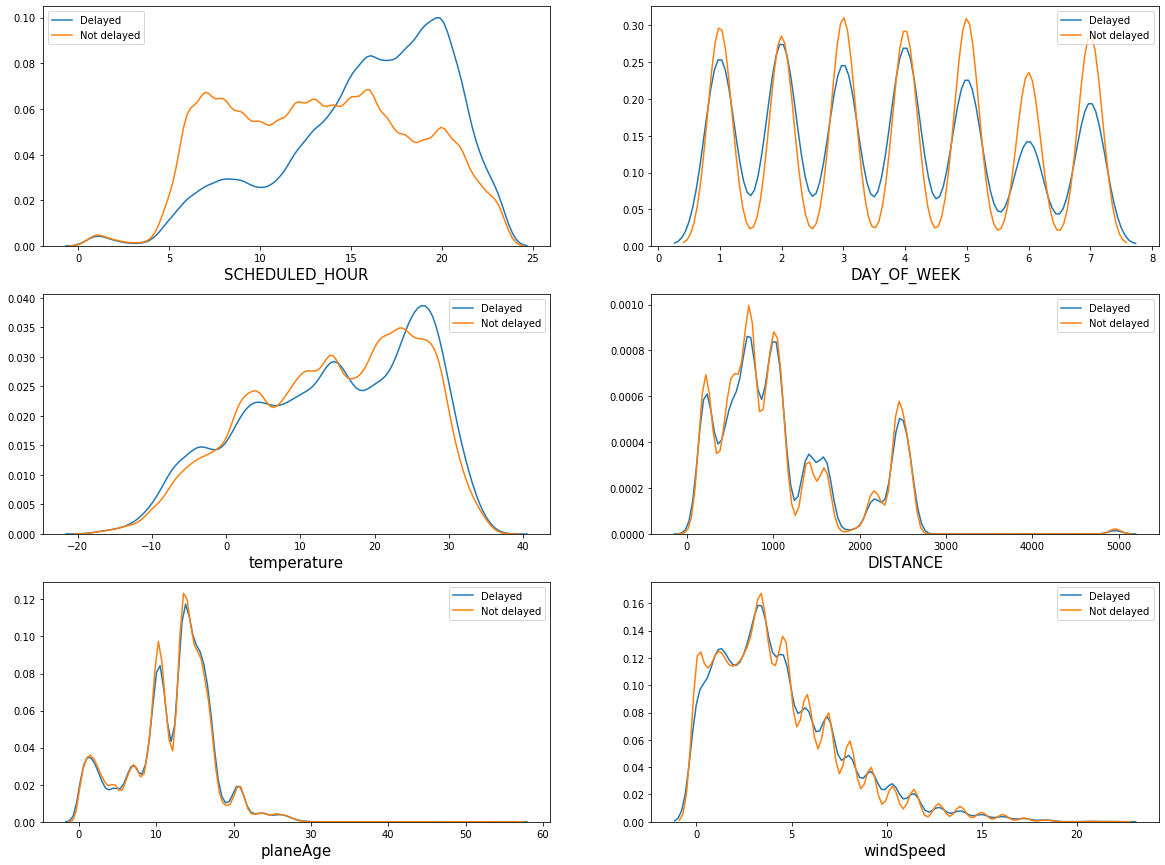

In [215]:
# Explore impact of continuous predictors on flight delay

feature = ['SCHEDULED_HOUR','DAY_OF_WEEK','temperature','DISTANCE','planeAge','windSpeed']
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20,15))

for i, ax in zip(range(len(feature)), axes.flat):    
    sns.distplot(dfdelay1[[feature[i]]], hist=False, label='Delayed', ax=ax)
    sns.distplot(dfdelay0[[feature[i]]], hist=False, label='Not delayed', ax=ax)
    ax.set_xlabel(feature[i],fontsize=15)
plt.show()

# 5. Feature Selection

In [15]:
df.columns

Index(['DAY_OF_WEEK', 'SCHEDULED_HOUR', 'DEPARTURE', 'DISTANCE', 'DELAY',
       'temperature', 'windSpeed', 'planeAge', 'United', 'weather_cloudy',
       'weather_fog', 'weather_rain', 'weather_sleet', 'weather_snow'],
      dtype='object')

In [216]:
# Check statistical significance of categorical variables on delay

from scipy.stats import chisquare
test_table1 = (pd.pivot_table(df, values='DISTANCE', index=['DELAY'], columns=['weather_snow'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T
test_table2 = (pd.pivot_table(df, values='DISTANCE', index=['DELAY'], columns=['weather_fog'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T
test_table3 = (pd.pivot_table(df, values='DISTANCE', index=['DELAY'], columns=['United'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T
test_table4 = (pd.pivot_table(df, values='DISTANCE', index=['DELAY'], columns=['DEPARTURE'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T

display('Chi-test: Does SNOW impact flight punctuality?')
display(test_table1, f'p-value = {chisquare(test_table1)[1][0]}')
display('Chi-test: Does FOG impact flight punctuality?')
display(test_table2, f'p-value = {chisquare(test_table2)[1][0]}')
display('Chi-test: Is UNITED Airlines worse than others on flight punctuality?')
display(test_table3, f'p-value = {chisquare(test_table3)[1][0]}')
display('Chi-test: Are DEPARTING flights more likely to be delayed?')
display(test_table4, f'p-value = {chisquare(test_table4)[1][0]}')

'Chi-test: Does SNOW impact flight punctuality?'

array([[143335,    320],
       [ 41197,    290]])

'p-value = 0.0'

'Chi-test: Does FOG impact flight punctuality?'

array([[141492,   2163],
       [ 40424,   1063]])

'p-value = 0.0'

'Chi-test: Is UNITED Airlines worse than others on flight punctuality?'

array([[ 35763, 107892],
       [  8893,  32594]])

'p-value = 0.0'

'Chi-test: Are DEPARTING flights more likely to be delayed?'

array([[72556, 71099],
       [19939, 21548]])

'p-value = 0.0'

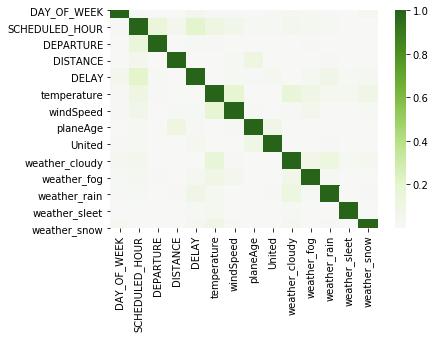

In [17]:
# Double check there is no strong collinearity between predictors

dfcorr = df.iloc[:]
sns.heatmap(abs(dfcorr.corr()), cmap="PiYG", center=0)
plt.show()

In [18]:
print('List of predictors and target to be fed into model')
display(df.dtypes)
display(df.shape)

List of predictors and target to be fed into model


DAY_OF_WEEK         int64
SCHEDULED_HOUR      int64
DEPARTURE           int64
DISTANCE            int64
DELAY               int64
temperature       float64
windSpeed         float64
planeAge          float64
United              int64
weather_cloudy      uint8
weather_fog         uint8
weather_rain        uint8
weather_sleet       uint8
weather_snow        uint8
dtype: object

(185142, 14)

In [19]:
df0.columns

Index(['DATE', 'DAY_OF_WEEK', 'SCHEDULED_HOUR', 'DEPARTURE', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 'DELAY',
       'DELAY_REASON', 'weather', 'precipIntensity', 'temperature',
       'windSpeed', 'visibility', 'planeAge'],
      dtype='object')

### Summary of predictors
**Target** = Delayed by at least 15 minutes [Yes=1/No=0]

**Predictors Category 1 : Scheduling-related**
1. Hour of the day  
2. Day of the week  
3. Departure or arrival [Yes=1/No=0]  
4. Distance of flight route in miles

**Predictors Category 2 : Weather-related**
5. Wind speed in mph
6. Temperature in C
7. Type of weather - rain, snow, sleet, fog, cloudy [Yes=1/No=0] (5 predictors)

**Predictors Category 3 : Airline-related**
12. United Airlines or competitors [Yes=1/No=0]
13. Age of aircraft in years




# 6. Prepare for modelling

In [20]:
# Prepocessing
import itertools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Logistic regression
from sklearn.linear_model import LogisticRegression

# Decision trees & ensemble methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Classifiers: KNN & SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

### 6.1 Train-Test split, Class imbalance and Standardization

In [21]:
# Split target and predictors
y = df['DELAY']
X = df.drop('DELAY', axis=1)

# Split test data
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.30, random_state=42)

In [22]:
# Standardize data
scaler = StandardScaler()
scaler.fit(X_train) # fit to Train only

X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


In [23]:
# Majority of flights are not delayed. Handle imbalance data using SMOTE:
print('Original train set')
display(pd.Series(y_train).value_counts())

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)
print('Training after treating class imbalance')
display(pd.Series(y_train).value_counts())

smote = SMOTE()
X_val, y_val = smote.fit_sample(X_val, y_val)
print('Validation after treating class imbalance')
display(pd.Series(y_val).value_counts())

Original train set


0    70445
1    20274
Name: DELAY, dtype: int64

Training after treating class imbalance


1    70445
0    70445
Name: DELAY, dtype: int64

Validation after treating class imbalance


1    30139
0    30139
Name: DELAY, dtype: int64

### 6.2 Automate processes

In [24]:
# Automate Confusion Matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, f1_score, auc

# Save result of each confusion matrix to be compared between different models later
def cf_measures(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cf_matrix[0][0], cf_matrix[0][1], cf_matrix[1][0], cf_matrix[1][1]
    TPR = round(TP/(TP+FN),4) # Power
    FPR = round(FP/(FP+TN),4) # Alpha
    FNR = round(FN/(FN+TP),4) # Beta
    TNR = round(TN/(TN+FN),4)
    Acc = round((TP+TN)/np.sum(cf_matrix),4)
    Pre = round(TP/(TP+FP),4)
    F1S = round(f1_score(y, y_pred),4)
    return TPR, FPR, FNR, TNR, Acc, Pre, F1S

# Plot confusion matrix and display summary
def cf_matrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    plt.imshow(cf_matrix,  cmap=plt.cm.Blues)
    thresh = cf_matrix.max() / 2.  
    for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
            plt.text(j, i, cf_matrix[i, j],
                     horizontalalignment='center', fontsize=12,
                     color='white' if cf_matrix[i, j] > thresh else 'black')
    plt.ylabel('TRUE Delay')
    plt.xlabel('PREDICTED Delay')
    plt.xticks([0,1])
    
    TPR, FPR, FNR, TNR, Acc, Pre, F1S = cf_measures(y, y_pred)    
    print (f'FalsePos={round(FPR*100,2)}%, FalseNeg={round(FNR*100,2)}%')
    print(f'TruePos={round(TPR*100,2)}%, TrueNeg={round(TNR*100,2)}%')
    print(f'Accuracy={round(Acc*100,2)}%, Precision={round(Pre*100,2)}%')
    print(f'F1score={round(F1S*100,2)}%')
    return ('Confusion Matrix:')

In [25]:
from sklearn.metrics import roc_auc_score
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1
        
from sklearn.metrics import roc_curve, auc
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(5,5))
    fpr1, tpr1, threshold1 = roc_curve(y_train, train_prob)
    plt.plot(fpr1, tpr1)    
    fpr2, tpr2, threshold2 = roc_curve(y_val, val_prob)
    plt.plot(fpr2, tpr2)            
    auc_train = round(auc(fpr1, tpr1),4)
    auc_val   = round(auc(fpr2, tpr2),4)    
   #annot(fpr, tpr, threshold)    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('True Positive (power)')
    plt.xlabel('False Positive (alpha)')
    plt.legend(['Train','Validation'])
    plt.show()
    print(f'AUC train: {round(auc_train*100,2)}%, AUC validation: {round(auc_val*100,2)}%')
    return auc_train, auc_val  
    
def opt_plots(opt_model, index, column):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index=index,columns=column,values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index=index,columns=column,values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')
#   return opt

In [26]:
# ***************Automate roc_curve, auc (OLD) *******************
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# %matplotlib inline

# def plot_roc_auc(X_train, y_train, X_val, y_val, trained_model, title=f'ROC curve and AUC'):
#     FPR1, TPR1, thresholds1 = roc_curve(y_train, trained_model.predict_proba(X_train)[:,1])
#     FPR2, TPR2, thresholds2 = roc_curve(y_val, trained_model.predict_proba(X_val)[:,1])
#     AUC1 = auc(FPR1, TPR1)
#     AUC2 = auc(FPR2, TPR2)
    
#     plt.figure()
#     lw = 2
#     plt.plot(FPR1, TPR1, color='blue', lw=lw, label='Training')
#     plt.plot(FPR2, TPR2, color='red', lw=lw, label='Validation', linestyle='dashdot')
    
#     plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='dashed')
#     plt.xlim([-0.01, 1.0])
#     plt.ylim([0.0, 1.01])
#     plt.xlabel('False Pos rate')
#     plt.ylabel('True Pos rate')
#     plt.title(title)
#     plt.legend(loc='lower right')
#     plt.show()
#     return print(f'AUC: Train={round(AUC1*100,2)}%, Validation={round(AUC2*100,2)}%')

### 6.3 Explore PCA

k=5, 0.42166
k=10, 1.0


[0.09515508 0.08873421 0.08097448 0.08003259 0.07676595]


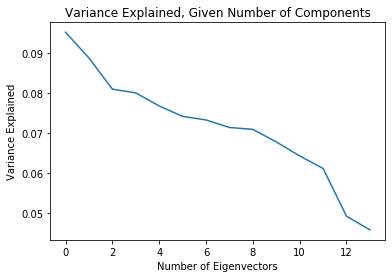

In [27]:
# PCA

df_TF = StandardScaler().fit_transform(df)
fit = PCA()
pca = fit.fit_transform(df_TF)
k=5

plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")

print(f'k={k}, {round(fit.explained_variance_ratio_[:k].sum(),5)}')
print(f'k={10}, {round(fit.explained_variance_ratio_[:35].sum(),5)}')
print('\n')
print(fit.explained_variance_ratio_[:k])

In [28]:
# Conclusion: Cumulative unexplained variance does not drop to zero fast enough with increasing PCA component.
# This results suggest that predictors are orthogonal to each other.
# Therefore we will not implement PCA in training the models below.

# 7. Train and evaluate models

Models to explore:
1. Logistic Regression as Baseline
2. Decision Tree
3. Random Forest
4. AdaBoost
5. Gradient Boost

Limited attempt due computational resource issues:
6. Support Vector Machines

### 7.1 Logistic Regression as Baseline
Hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Start: 15:39:23
End: 15:39:23 in 0.0 minutes


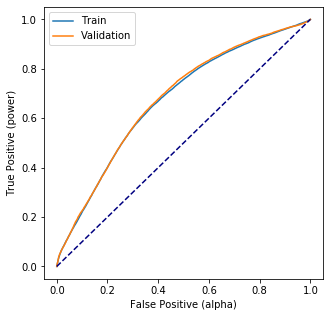

AUC train: 67.26%, AUC validation: 67.71%


In [29]:
# Baseline: Logistic Regression with default hyperparameters

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

baseline = LogisticRegression(random_state=42)
baseline.fit(X_train,y_train)

print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

scores(baseline,X_train,X_val,y_train,y_val)
auc_train, auc_val = roc_plot(baseline,X_train,y_train,X_val,y_val)

In [30]:
# Baseline: Logistic Regression parameter tuning with GridsearchCV

# penalty: {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
# dual: bool, default=False
# tol: float, default=1e-4
# C: float, default=1.0
# fit_intercept: bool, default=True
# intercept_scaling: float, default=1
# class_weight: dict or ‘balanced’, default=None
# random_state: int, RandomState instance, default=None
# solver: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
# max_iter: int, default=100
# multi_class: {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
# verbose: int, default=0
# warm_start: bool, default=False
# n_jobs: int, default=None
# l1_ratio: float, default=None

model = baseline
start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
      
param_grid = {'C':[1,1e2,1e3,1e4,1e5],'penalty':['l1', 'l2'],'solver':['lbfgs', 'saga']}

opt_model = GridSearchCV(model,param_grid,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
      
print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)

Start: 15:39:24
End: 15:39:57 in 0.5 minutes
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


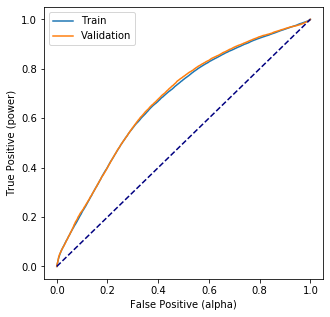

AUC train: 67.26%, AUC validation: 67.71%
FalsePos=39.39%, FalseNeg=33.66%
TruePos=66.34%, TrueNeg=64.29%
Accuracy=63.47%, Precision=62.74%
F1score=64.49%


'Confusion Matrix:'

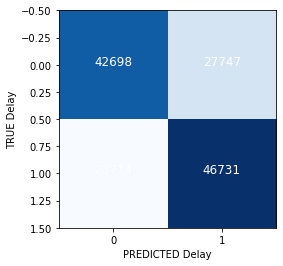

In [31]:
# Baseline: Logistic Regression with optimized hyperparameters:

best_baseline = best_model
filename = 'pickle_baseline.sav'
pickle.dump(best_baseline, open(filename, 'wb'))

scores(best_baseline,X_train,X_val,y_train,y_val)
auc_train, auc_val = roc_plot(best_baseline,X_train,y_train,X_val,y_val)

y_pred_train = best_baseline.predict(X_train)
baseline_measures = cf_measures(y_train, y_pred_train) + tuple([auc_train, auc_val])
display(cf_matrix(y_train, y_pred_train))
display(best_baseline)

### 7.2 Decision Tree
Hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Start: 15:39:59
End: 15:40:01 in 0.0 minutes


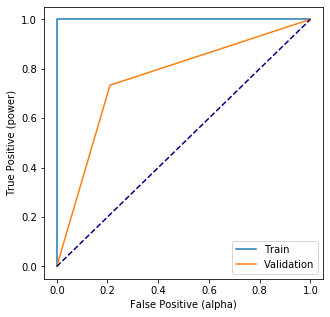

AUC train: 100.0%, AUC validation: 76.18%


(1.0, 0.7618)

In [32]:
# Decision Tree with default hyperparameters

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train,y_train)

print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

scores(dtree,X_train,X_val,y_train,y_val)
roc_plot(dtree,X_train,y_train,X_val,y_val)

Start: 15:40:02
End: 15:40:30 in 0.5 minutes
{'max_depth': 30, 'min_samples_leaf': 50}


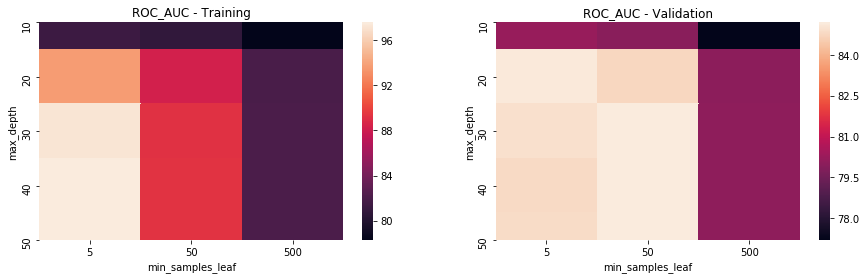

In [33]:
# Decision Tree parameter tuning with GridsearchCV

# criterion: {“gini”, “entropy”}, default=”gini”
# splitter: {“best”, “random”}, default=”best”
# max_depth: int, default=None *** TO BE TUNED ***
# min_samples_split: int or float, default=2
# min_samples_leaf: int or float, default=1 *** TO BE TUNED ***
# min_weight_fraction_leaf: float, default=0.0
# max_features: int, float or {“auto”, “sqrt”, “log2”}, default=None
# random_state: int or RandomState, default=None
# max_leaf_nodes: int, default=None
# min_impurity_decrease: float, default=0.0
# min_impurity_split: float, default=1e-7
# class_weight: dict, list of dict or “balanced”, default=None
# ccp_alpha: non-negative float, default=0.0

model = dtree
start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
      
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
      
print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
      
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model, 'max_depth', 'min_samples_leaf')

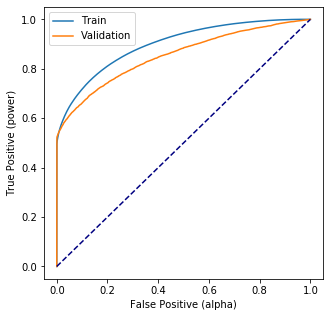

AUC train: 89.85%, AUC validation: 85.32%
FalsePos=12.98%, FalseNeg=24.91%
TruePos=75.09%, TrueNeg=77.74%
Accuracy=81.05%, Precision=85.26%
F1score=79.85%


'Confusion Matrix:'

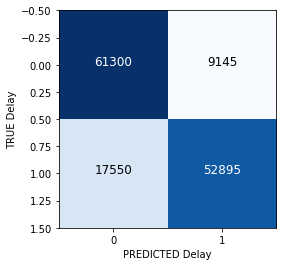

In [34]:
# Decision Tree GridsearchCV best model result - Round 1

scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

y_pred_train = best_model.predict(X_train)
display(cf_matrix(y_train, y_pred_train))

Start: 15:40:32
End: 15:41:51 in 1.3 minutes
{'max_depth': 45, 'min_samples_leaf': 20}


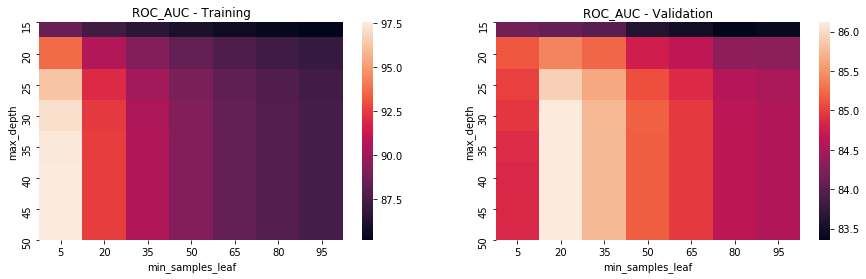

In [35]:
# Decision Tree GridsearchCV best model result - Round 2

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
      
param_grid = {'max_depth':range(15,50+1,5),'min_samples_leaf':range(5,100+1,15)}

opt_model = GridSearchCV(model,param_grid,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
      
print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
      
scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model, 'max_depth', 'min_samples_leaf')

In [43]:
# Decision Tree GridsearchCV best model result - Round 3 (pickled after running)

# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
      
# param_grid = {'max_depth':range(15,50+1,5),'min_samples_leaf':range(5,35)}

# opt_model = GridSearchCV(model,param_grid,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1)
# opt_model.fit(X_train,y_train)
# best_model = opt_model.best_estimator_
      
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
      
# filename = 'pickle_dtree_gs.sav'
# pickle.dump(opt_model, open(filename, 'wb'))

{'max_depth': 35, 'min_samples_leaf': 13}


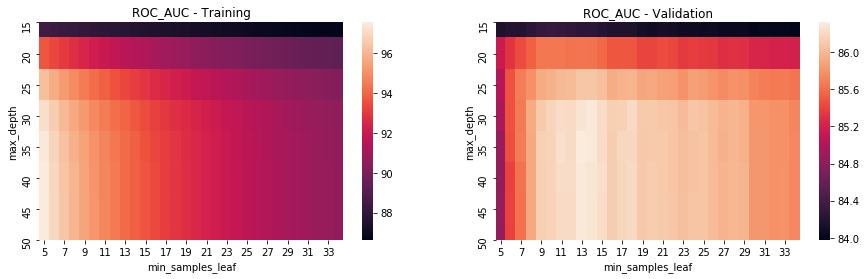

In [42]:
# Decision Tree GridsearchCV best model result - Round 3 (open from pickle)

filename = 'pickle_dtree_gs.sav'
opt_model = pickle.load(open(filename, 'rb'))
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model, 'max_depth', 'min_samples_leaf')

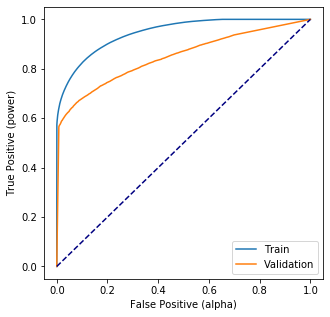

AUC train: 94.63%, AUC validation: 84.73%
FalsePos=10.34%, FalseNeg=17.22%
TruePos=82.78%, TrueNeg=83.89%
Accuracy=86.22%, Precision=88.89%
F1score=85.73%


'Confusion Matrix:'

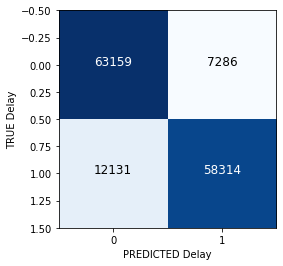

In [44]:
# Decision Tree best model with optimized hyperparameters:

best_dtree = best_model

scores(best_dtree,X_train,X_val,y_train,y_val)
auc_train, auc_val = roc_plot(best_dtree,X_train,y_train,X_val,y_val)

y_pred_train = best_dtree.predict(X_train)
dtree_measures = cf_measures(y_train, y_pred_train) + tuple([auc_train, auc_val])
display(cf_matrix(y_train, y_pred_train))
display(best_dtree)

### 7.3 Random Forest
Hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Start: 15:58:28
End: 15:59:10 in 0.7 minutes


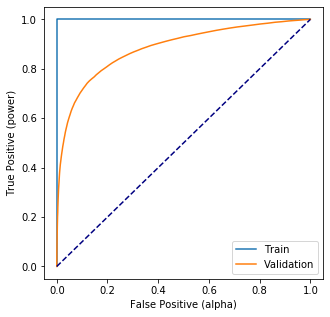

AUC train: 100.0%, AUC validation: 88.29%


(1.0, 0.8829)

In [45]:
# Random Forest with default hyperparameters

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

rforest = RandomForestClassifier(random_state=42)
rforest.fit(X_train,y_train)

print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

scores(rforest,X_train,X_val,y_train,y_val)
roc_plot(rforest,X_train,y_train,X_val,y_val)

In [49]:
# Random Forest parameter tuning with GridSearch CV (pickled after running)
#
# n_estimators: integer, optional (default=100)
# criterion: string, optional (default=”gini”)
# max_depth: integer or None, optional (default=None)
# min_samples_split: int, float, optional (default=2)
# min_samples_leaf: int, float, optional (default=1)
# min_weight_fraction_leaf: float, optional (default=0.)
# max_features: int, float, string or None, optional (default=”auto”)
# max_leaf_nodes: int or None, optional (default=None)
# min_impurity_decrease: float, optional (default=0.)
# bootstrap: boolean, optional (default=True)
# oob_score: bool (default=False)
# n_jobs: int or None, optional (default=None)
# random_state: int, RandomState instance or None, optional (default=None)
# warm_start: bool, optional (default=False)
# class_weight: dict, list of dicts, “balanced”, “balanced_subsample” or None, optional (default=None)
# ccp_alpha: non-negative float, optional (default=0.0)
# max_samples: int or float, default=None

# model = rforest
# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
      
# param_grid = {'max_depth':[35, 45], 'min_samples_leaf':[13], 'n_estimators':[100, 300]}

# opt_model = GridSearchCV(model,param_grid,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1)
# opt_model.fit(X_train,y_train)
# best_model = opt_model.best_estimator_
      
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
      
# filename = 'pickle_rforest.sav'
# pickle.dump(best_model, open(filename, 'wb'))

Start: 16:08:52
End: 16:15:47 in 6.9 minutes


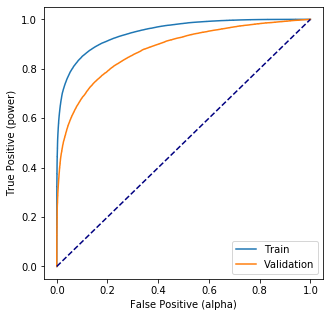

AUC train: 94.84%, AUC validation: 87.8%
FalsePos=10.3%, FalseNeg=14.76%
TruePos=85.24%, TrueNeg=85.87%
Accuracy=87.47%, Precision=89.22%
F1score=87.19%


'Confusion Matrix:'

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=45, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

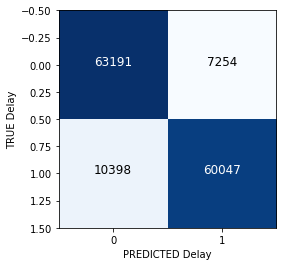

In [57]:
# Random Forest GridsearchCV best model result (open from pickle)

filename = 'pickle_rforest.sav' # note: file size = 167 MB
best_model = pickle.load(open(filename, 'rb'))

best_rforest = best_model

scores(best_rforest,X_train,X_val,y_train,y_val)
auc_train, auc_val = roc_plot(best_rforest,X_train,y_train,X_val,y_val)

y_pred_train = best_rforest.predict(X_train)
rforest_measures = cf_measures(y_train, y_pred_train) + tuple([auc_train, auc_val])
display(cf_matrix(y_train, y_pred_train))
display(best_rforest)

### 7.4 AdaBoost
Hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Start: 16:57:52
End: 16:58:04 in 0.2 minutes


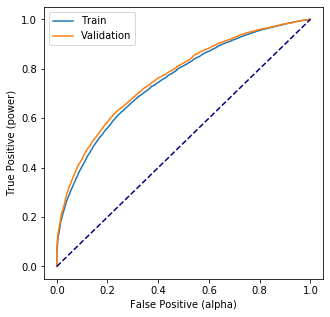

AUC train: 75.1%, AUC validation: 76.43%


(0.751, 0.7643)

In [59]:
# AdaBoost with default hyperparameters

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train,y_train)

print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

scores(adaboost,X_train,X_val,y_train,y_val)
roc_plot(adaboost,X_train,y_train,X_val,y_val)

Start: 17:15:34
End: 17:19:08 in 3.6 minutes
{'learning_rate': 1, 'n_estimators': 150}


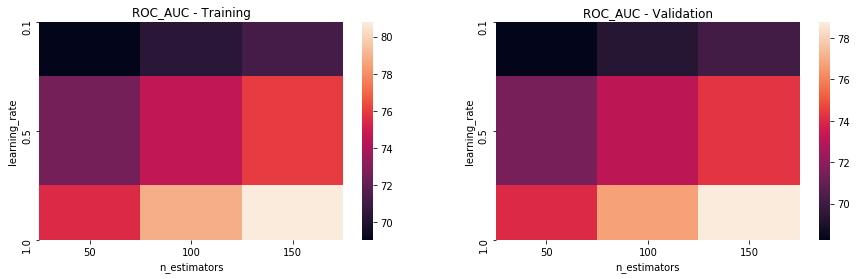

In [64]:
# Adaboost parameter tuning - Round 1
#
# base_estimator: object, optional (default=None)
# n_estimators: int, optional (default=50)
# learning_rate: float, optional (default=1.)
# algorithm: {‘SAMME’, ‘SAMME.R’}, optional (default=’SAMME.R’)
# random_state: int, RandomState instance or None, optional (default=None)

model = adaboost
start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
      
param_grid = {'learning_rate':[0.1,0.5, 1], 'n_estimators':[50, 100, 150]}

opt_model = GridSearchCV(model,param_grid,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_
      
print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model, 'learning_rate', 'n_estimators')

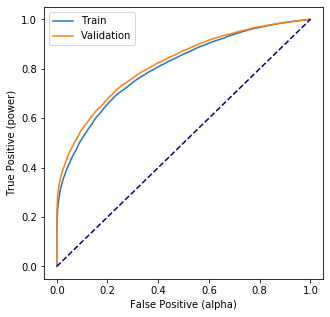

AUC train: 80.41%, AUC validation: 81.92%
FalsePos=27.98%, FalseNeg=27.17%
TruePos=72.83%, TrueNeg=72.61%
Accuracy=72.42%, Precision=72.24%
F1score=72.53%


'Confusion Matrix:'

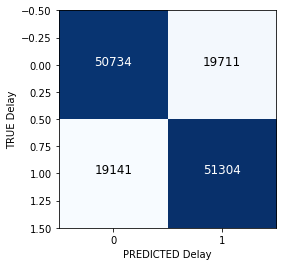

In [65]:
# Adaboost parameter tuning - Round 1

scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

y_pred_train = best_model.predict(X_train)
display(cf_matrix(y_train, y_pred_train))

In [69]:
# Adaboost parameter tuning - Round 2 (picked after running)

# model = adaboost
# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
      
# param_grid = {'learning_rate':[1], 'n_estimators':[150,200,250,300]}

# opt_model = GridSearchCV(model,param_grid,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1)
# opt_model.fit(X_train,y_train)
# best_model = opt_model.best_estimator_
      
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

# scores(best_model,X_train,X_val,y_train,y_val)
# print(opt_model.best_params_)
# opt_plots(opt_model, 'learning_rate', 'n_estimators')
      
# filename = 'pickle_adaboost_gs.sav'
# pickle.dump(opt_model, open(filename, 'wb'))

{'learning_rate': 1, 'n_estimators': 300}


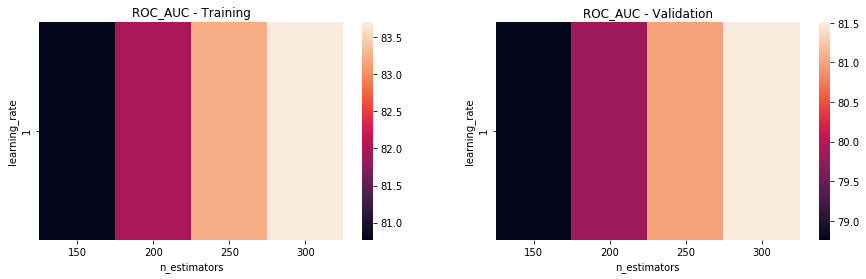

In [70]:
# Decision Tree GridsearchCV best model result - Round 3 (open from pickle)

filename = 'pickle_adaboost_gs.sav'
opt_model = pickle.load(open(filename, 'rb'))
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model, 'learning_rate', 'n_estimators')

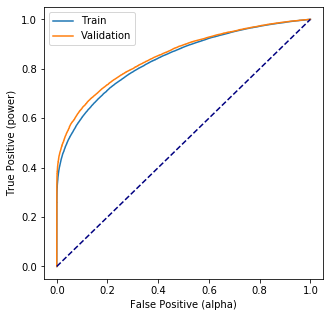

AUC train: 83.82%, AUC validation: 85.11%
FalsePos=23.05%, FalseNeg=26.08%
TruePos=73.92%, TrueNeg=74.69%
Accuracy=75.44%, Precision=76.23%
F1score=75.06%


'Confusion Matrix:'

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=300, random_state=42)

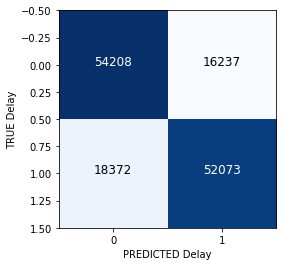

In [71]:
# AdaBoost GridsearchCV best model result (open from pickle)

best_adaboost = best_model

scores(best_adaboost,X_train,X_val,y_train,y_val)
auc_train, auc_val = roc_plot(best_adaboost,X_train,y_train,X_val,y_val)

y_pred_train = best_adaboost.predict(X_train)
adaboost_measures = cf_measures(y_train, y_pred_train) + tuple([auc_train, auc_val])
display(cf_matrix(y_train, y_pred_train))
display(best_adaboost)

### 7.5 Gradient Boost
Hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Start: 17:38:04
End: 17:38:43 in 0.7 minutes


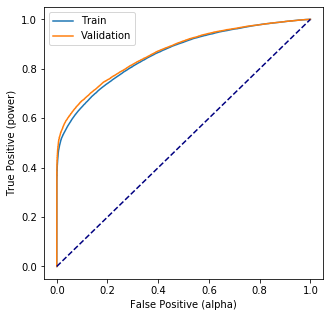

AUC train: 85.94%, AUC validation: 86.72%
FalsePos=19.92%, FalseNeg=26.0%
TruePos=74.0%, TrueNeg=75.49%
Accuracy=77.04%, Precision=78.79%
F1score=76.32%


'Confusion Matrix:'

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

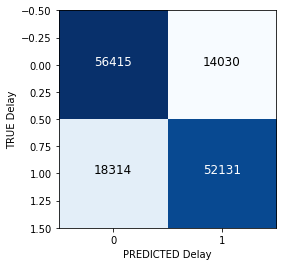

In [73]:
# Gradient Boost with default hyperparameters

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

gboost = GradientBoostingClassifier(random_state=42)
gboost.fit(X_train,y_train)

print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

scores(gboost,X_train,X_val,y_train,y_val)
auc_train, auc_val = roc_plot(gboost,X_train,y_train,X_val,y_val)

y_pred_train = gboost.predict(X_train)
gboost_measures = cf_measures(y_train, y_pred_train) + tuple([auc_train, auc_val])
display(cf_matrix(y_train, y_pred_train))
display(gboost)

### 7.6 Support Vector Machines
Hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [82]:
# SVC with default hyperparameters, max_iter:10,000 (pickled after running)
# run time = 93 minutes

# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

# svc = SVC(max_iter=1e4, probability=True, random_state=42)
# svc.fit(X_train,y_train)

# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
      
# filename = 'pickle_svc2.sav'
# pickle.dump(svc, open(filename, 'wb'))

Start: 18:06:18
End: 19:39:45 in 93.4 minutes


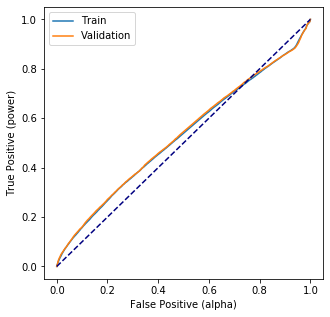

AUC train: 52.63%, AUC validation: 52.96%


(0.5263, 0.5296)

In [85]:
# SVC with default hyperparameters

filename = 'pickle_svc2.sav'
svc2 = pickle.load(open(filename, 'rb'))
scores(svc2,X_train,X_val,y_train,y_val)
roc_plot(svc2,X_train,y_train,X_val,y_val)

In [ ]:
# SVC model doesn't converge after 10,000 iterations in 93 minutes
# Due to computational resource limitation, we will not further explore this model.

# 8. Finalize model

### 8.1 Model selection

In [74]:
# Summary of results from all explored models

results_list = [['Baseline: Logistic reg'] + ['{C:1, penalty:l1, solver:saga}'] + list(baseline_measures),
                ['Decision Tree'] + ['{max_depth:35, min_samples_leaf:13}'] + list(dtree_measures),
                ['Random Forest'] + ['{max_depth:45, n_estimators:300}'] + list(rforest_measures),
                ['AdaBoost'] + ['{learning_rate:1, n_estimators:300}'] + list(adaboost_measures),
                ['Gradient Boost'] + ['default'] + list(gboost_measures)
               ]

results_table = pd.DataFrame(columns=['Measures', 'Hyperparams',
                                      'TruePos', 'FalsePos', 'FalseNeg', 'TrueNeg',
                                      'Accuracy', 'Precision', 'F1 score',
                                      'AUC train', 'AUC val'])
for result in results_list:
    results_table.loc[len(results_table)] = result
print('Summary of results from training models:')
results_table

Summary of results from training models:


,Measures,Hyperparams,TruePos,FalsePos,FalseNeg,TrueNeg,Accuracy,Precision,F1 score,AUC train,AUC val
0,Baseline: Logistic reg,"{C:1, penalty:l1, solver:saga}",0.6634,0.3939,0.3366,0.6429,0.6347,0.6274,0.6449,0.6726,0.6771
1,Decision Tree,"{max_depth:35, min_samples_leaf:13}",0.8278,0.1034,0.1722,0.8389,0.8622,0.8889,0.8573,0.9463,0.8473
2,Random Forest,"{max_depth:45, n_estimators:300}",0.8524,0.1030,0.1476,0.8587,0.8747,0.8922,0.8719,0.9484,0.8780
3,AdaBoost,"{learning_rate:1, n_estimators:300}",0.7392,0.2305,0.2608,0.7469,0.7544,0.7623,0.7506,0.8382,0.8511
4,Gradient Boost,default,0.7400,0.1992,0.2600,0.7549,0.7704,0.7879,0.7632,0.8594,0.8672


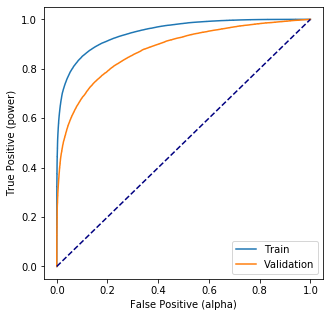

AUC train: 94.84%, AUC validation: 87.8%
FalsePos=10.3%, FalseNeg=14.76%
TruePos=85.24%, TrueNeg=85.87%
Accuracy=87.47%, Precision=89.22%
F1score=87.19%


'Confusion Matrix:'

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=45, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

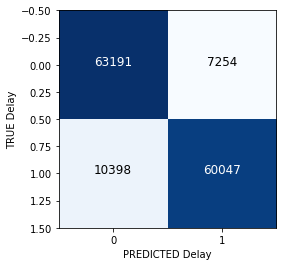

In [88]:
# Final model selected = RANDOM FOREST
# based tradeoffs between confusion matrix measures and train/validation AUC

scores(best_rforest,X_train,X_val,y_train,y_val)
auc_train, auc_val = roc_plot(best_rforest,X_train,y_train,X_val,y_val)

y_pred_train = best_rforest.predict(X_train)
rforest_measures = cf_measures(y_train, y_pred_train) + tuple([auc_train, auc_val])
display(cf_matrix(y_train, y_pred_train))
display(best_rforest)

### 8.2 Feature Importance

In [188]:
# List of predictors and its corresponding feature importance weight

features = list(df.columns)
features.remove('DELAY')
features_weight = best_rforest.feature_importances_
features_table = pd.DataFrame(columns=['Feature','Weight'], index=list(range(len(features))))

for n in range(len(features)):
    features_table['Feature'].loc[n] = features[n]
    features_table['Weight'].loc[n]  = round(features_weight[n],3)

features_table = features_table.sort_values(by=['Weight'], ascending=False)
features_table.index = np.arange(1, len(features_table) + 1)
features_table

,Feature,Weight
1,SCHEDULED_HOUR,0.369
2,DAY_OF_WEEK,0.136
3,DISTANCE,0.127
4,temperature,0.119
5,windSpeed,0.105
6,planeAge,0.078
7,DEPARTURE,0.018
8,weather_rain,0.016
9,United,0.012
10,weather_cloudy,0.01


### 8.3 Threshold selection

In [227]:
# For selected Random Forest:

TPR = dtree_measures[0]
FPR = dtree_measures[0]
Prevalence = len(dfdelay1)/len(df0)
# Cost_penalty = (cost of FP - cost of TN) / (cost of FN - cost of TP)
Cost_penalty = 0.1
Metz_m = (1-Prevalence)/Prevalence * Cost_penalty
fm = TPR - Metz_m * FPR

print(f'Adjusted threshold = {round(fm,3)}')


Adjusted threshold = 0.541


### 8.4 Final model evaluation with Test data

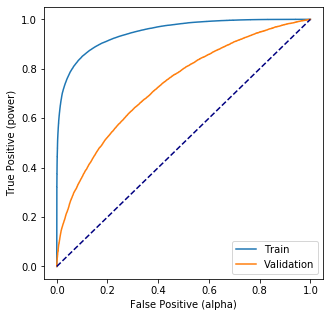

AUC train: 94.84%, AUC validation: 73.09%
FalsePos=15.29%, FalseNeg=54.47%
TruePos=45.53%, TrueNeg=84.3%
Accuracy=75.91%, Precision=46.31%
F1score=45.92%


'Confusion Matrix:'

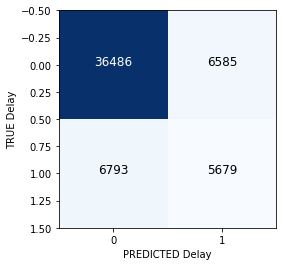

In [228]:
# Evaluate Random Forest model with Test data:

scores(best_rforest,X_train,X_test,y_train,y_test)
auc_train, auc_test = roc_plot(best_rforest,X_train,y_train,X_test,y_test)

y_pred_test = best_rforest.predict(X_test)
display(cf_matrix(y_test, y_pred_test))

# 9. Conclusion and recommendation